# DBSCAN

We run DBSCAN clustering on the full cardinality of the data obtained from _greg-features.ipynb_. But we only use the columns retained after running _centroid-sampling.ipynb_ and _dim-red-via-correlation.ipynb_.

Reference material:

* [sklearn DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
* [DBSCAN demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
* [Let’s cluster data points using DBSCAN](https://medium.com/@agarwalvibhor84/lets-cluster-data-points-using-dbscan-278c5459bee5)

<hr>

In [1]:
%pylab inline
%autosave 25

import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


### Data location

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

### Get the full data set

In [3]:
store = pd.HDFStore(data_loc + 'features.h5')
df_all = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_all), len(df_all.columns)))
store.close()

rows: 184,063, columns: 17,076


### Take a subset of the columns

Exclude zero-variance and highly correlated columns, as found from analysing the centroid-based sampled data set.

In [4]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
meta = store.select('df', start=1, stop=1) # Grab on the column names. Speeds things up.
cols = meta.columns
store.close()
print('columns: {:,}'.format(len(cols)))

columns: 14,730


### Original data with reduced dimensionality

In [5]:
df_features = df_all[cols]
del df_all
del cols
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 184,063, columns: 14,730


### Scale to range (0, 1)

Note: previsouly used StandardScaler on all columns except fingerprint and binding-sites but this took a lot of time and resources to calculate with no apparrent additional benefit. So switched to simpler MinMaxScaler over all columns.

In [6]:
scaler = MinMaxScaler()
drop_cols = ['cid', 'pid', 'activity']
features = df_features.drop(columns=drop_cols, axis=1)
features = scaler.fit_transform(features.values)

In [7]:
df_drop = df_features[drop_cols]
cols = df_features.columns.tolist()[3:]
del df_features

df_features = pd.DataFrame(columns=cols, data=features)
df_features[drop_cols] = pd.DataFrame(df_drop.values)

del df_drop
df_features.head()

,AEK,VEL,EKF,LGM,VKN,LKP,NEE,TPN,SRL,KEY,...,4089,4090,4091,4092,4093,4094,4095,cid,pid,activity
0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,CAA96025,0
1,0.616716,0.0,0.0,0.0,0.59088,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,XP_717710,0
2,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,O86157,0
3,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,P08659,0
4,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38258,ADQ57959,0


### Takes a while to scale so save for later

In [8]:
# save the scaled features to file to save running this slow op again
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
store['df'] = df_features
store.close()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->['cid', 'pid', 'activity']]

  exec(code_obj, self.user_global_ns, self.user_ns)


### Load pre-scaled data

In [3]:
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
df_features = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))
store.close()

rows: 184,063, columns: 14,730


## Cluster — DBSCAN

#### 1. Interpoint distances to estimate Eps

Plot interpoint distances over the centroid-sample set to see if we can determine a decent value for DBSCAN's epsilon parameter.

Do this by taking knn with _k = 3_ over a sample of the data and then plotting those distances. We look for a noticiable knee in the plot as a contender for DBSCAN epsilon.

Reference material:

* [scikit-learn: Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
* [Knn distance plot for determining eps of DBSCAN](https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan)

In [3]:
from sklearn.neighbors import NearestNeighbors

store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_sampled = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_sampled), len(df_sampled.columns)))
store.close()

df_sampled_sampled = df_sampled.sample(1000, random_state=42)
X = df_sampled_sampled.drop(['cid', 'pid', 'activity'], axis=1).values

X = MinMaxScaler().fit_transform(X)

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)

rows: 22,172, columns: 13,851


In [49]:
distances, indices = nbrs.kneighbors(X)
third_n = distances[:, 2]
third_n.sort(axis=0)

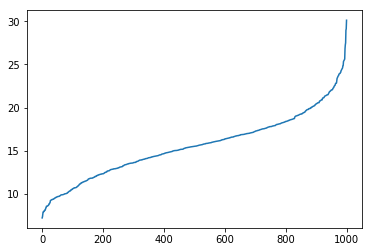

In [51]:
_ = plt.plot(third_n)

#### 2. Run DBSCAN

In [5]:
# Test out on a sample first.
X = df_features.sample(20000, random_state=39).drop(['cid', 'pid', 'activity'], axis=1).values
X.shape

(20000, 14727)

In [ ]:
db = DBSCAN(eps=10, min_samples=10).fit(X)

In [ ]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [ ]:
n_clusters_

In [ ]:
n_noise_

## Cluster — OPTICS

Reference material:

* [sklearn.cluster.OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)
* [OPTICS algorithm](https://en.wikipedia.org/wiki/OPTICS_algorithm)
* [Demo of OPTICS clustering algorithm](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html)

In [6]:
# Test on scaled, centroid-based sample.
store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_sampled = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_sampled), len(df_sampled.columns)))
store.close()

scaler = MinMaxScaler()
drop_cols = ['cid', 'pid', 'activity']
X = df_sampled.drop(columns=drop_cols, axis=1)
X = scaler.fit_transform(X.values)

rows: 22,172, columns: 13,851


In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]